# Market Saturation Analysis for Vancouver Airbnb Listings

This notebook analyzes the competitive landscape of Vancouver Airbnb market and identifies characteristics of successful listings.

## Objectives:
- Analyze market saturation by neighborhood
- Classify top-performing listings (top 20% by revenue)
- Perform feature importance analysis
- Calculate market concentration metrics
- Identify competitive positioning factors

In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [20]:
# Load the data
df = pd.read_csv('../data/listings-detail.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (5550, 79)
Columns: 79

First few rows:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13188,https://www.airbnb.com/rooms/13188,20250810152821,2025-08-10,city scrape,Garden level studio in ideal loc.,Garden level studio suite with garden patio - ...,The uber hip Main street area is a short walk ...,https://a0.muscache.com/pictures/8408188/e1af6...,51466,...,4.94,4.90,4.81,Municipal registration number: 25-156058<br />...,f,1,1,0,0,1.98
1,13358,https://www.airbnb.com/rooms/13358,20250810152821,2025-08-10,city scrape,Downtown Designer one bedroom,The iconic Electra Building.<br />A Vancouver ...,2 blocks away from the shopping area of Robson...,https://a0.muscache.com/pictures/miso/Hosting-...,52116,...,4.81,4.91,4.66,Municipal registration number: 25-157257<br />...,t,1,1,0,0,3.12
2,16611,https://www.airbnb.com/rooms/16611,20250810152821,2025-08-10,previous scrape,"1 block to skytrain station, shops,restaurant,...","My place is close to bank, coffee shops, groce...",Next block to Commercial Drive which has many ...,https://a0.muscache.com/pictures/82101/7127b63...,58512,...,4.33,5.00,3.67,NaN,f,5,5,0,0,0.03
3,18270,https://www.airbnb.com/rooms/18270,20250810152821,2025-08-10,city scrape,private rm in clean central 2BR apt,I have a bright furnished 2 bedroom suite on a...,"Lots of restaurants, coffee shops.<br />Easy a...",https://a0.muscache.com/pictures/108520241/aec...,70437,...,4.73,4.69,4.49,NaN,f,1,0,1,0,0.67
4,18589,https://www.airbnb.com/rooms/18589,20250810152821,2025-08-10,city scrape,Commercial Drive B&B,"As hosts, we are welcoming you into our home, ...",Lots of restaurants and boutiques just outside...,https://a0.muscache.com/pictures/dd3ca406-cb74...,71508,...,5.00,4.93,4.96,Municipal registration number: 25-155972<br />...,f,1,0,1,0,3.57


In [21]:
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [22]:
# Check data types and missing values
print("Data Info:")
df.info()

print("\nMissing Values Summary:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Percentage', ascending=False)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5550 entries, 0 to 5549
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5550 non-null   int64  
 1   listing_url                                   5550 non-null   object 
 2   scrape_id                                     5550 non-null   int64  
 3   last_scraped                                  5550 non-null   object 
 4   source                                        5550 non-null   object 
 5   name                                          5550 non-null   object 
 6   description                                   5489 non-null   object 
 7   neighborhood_overview                         2802 non-null   object 
 8   picture_url                                   5550 non-null   object 
 9   host_id                                       5550 n

,Missing Count,Missing Percentage
neighbourhood_group_cleansed,5550,100.000000
calendar_updated,5550,100.000000
host_about,2768,49.873874
neighborhood_overview,2748,49.513514
neighbourhood,2748,49.513514
host_location,1293,23.297297
license,1200,21.621622
estimated_revenue_l365d,911,16.414414
price,911,16.414414
bathrooms,904,16.288288


## 2. Exploratory Data Analysis

Revenue-related columns: ['estimated_revenue_l365d']

Using revenue column: estimated_revenue_l365d


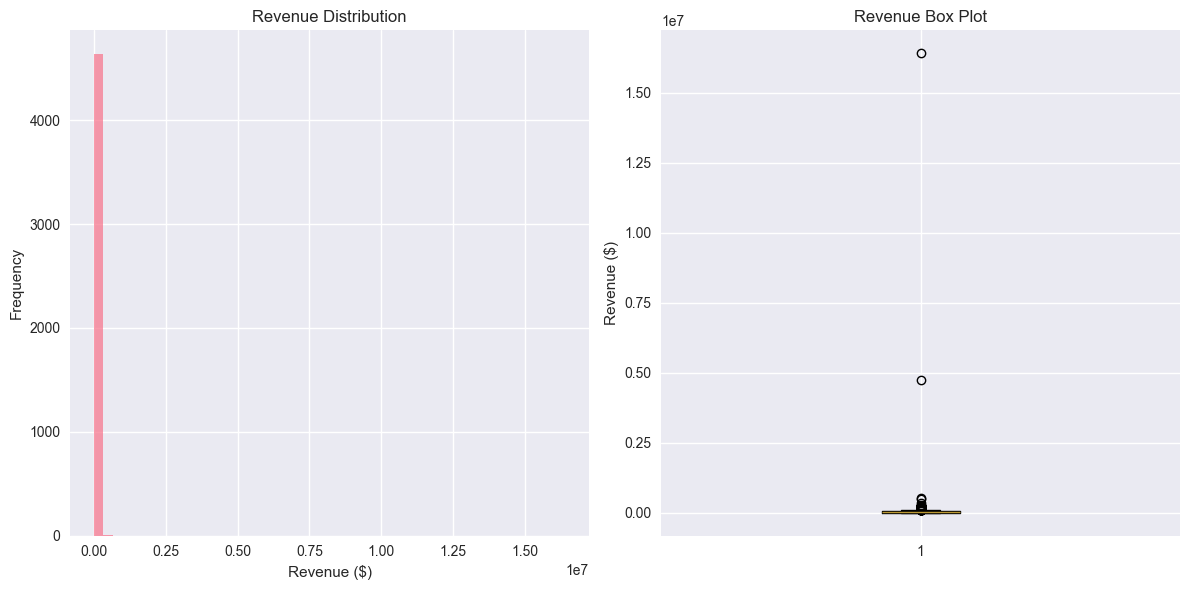

Revenue Statistics:
count    4.639000e+03
mean     3.714505e+04
std      2.529879e+05
min      0.000000e+00
25%      3.630000e+03
50%      2.346000e+04
75%      4.635000e+04
max      1.641180e+07
Name: estimated_revenue_l365d, dtype: float64


In [23]:
# Analyze revenue distribution
revenue_cols = [col for col in df.columns if 'revenue' in col.lower()]
print("Revenue-related columns:", revenue_cols)

if revenue_cols:
    revenue_col = revenue_cols[0]
    print(f"\nUsing revenue column: {revenue_col}")
    
    # Revenue distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df[revenue_col].dropna(), bins=50, alpha=0.7)
    plt.title('Revenue Distribution')
    plt.xlabel('Revenue ($)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df[revenue_col].dropna())
    plt.title('Revenue Box Plot')
    plt.ylabel('Revenue ($)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Revenue Statistics:")
    print(df[revenue_col].describe())

Market Saturation by Neighborhood:
                          total_listings  avg_price  avg_availability  \
neighbourhood_cleansed                                                  
Downtown                             996     370.77            178.51   
Kitsilano                            274     317.05            159.71   
Downtown Eastside                    280     308.70            171.94   
Kensington-Cedar Cottage             265     212.08            195.31   
Dunbar Southlands                    167     245.63            154.07   
Renfrew-Collingwood                  175     207.82            170.10   
Mount Pleasant                       249     224.41            211.31   
Riley Park                           195     571.06            185.13   
Hastings-Sunrise                     215     221.64            204.00   
Grandview-Woodland                   135     211.01            166.66   

                          avg_reviews  avg_rating  saturation_index  
neighbourhood_clea

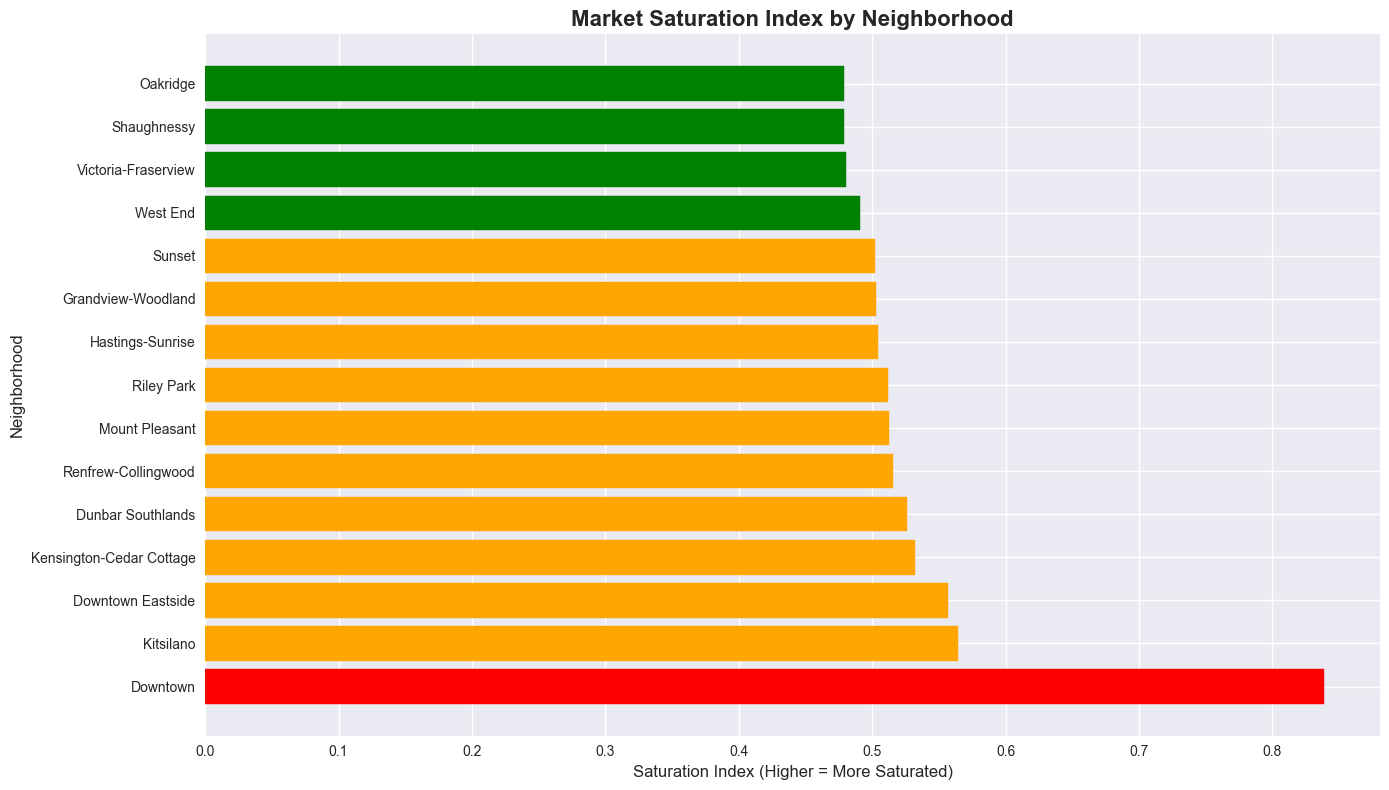

In [24]:
# Market saturation analysis by neighborhood
if 'neighbourhood_cleansed' in df.columns:
    # Convert numeric columns to proper types before aggregation
    df_numeric = df.copy()
    numeric_cols = ['price', 'availability_365', 'number_of_reviews', 'review_scores_rating']

    for col in numeric_cols:
        if col in df_numeric.columns:
            # Convert to numeric, handling any non-numeric values
            df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

    # Remove rows with NaN values in key columns
    df_numeric = df_numeric.dropna(subset=['price', 'availability_365', 'number_of_reviews', 'review_scores_rating'])

    # Calculate neighborhood statistics
    neighborhood_stats = df_numeric.groupby('neighbourhood_cleansed').agg({
        'id': 'count',
        'price': 'mean',
        'availability_365': 'mean',
        'number_of_reviews': 'mean',
        'review_scores_rating': 'mean'
    }).round(2)
    
    # Rename columns for clarity
    neighborhood_stats.columns = ['total_listings', 'avg_price', 'avg_availability', 'avg_reviews', 'avg_rating']
    
    # Filter neighborhoods with sufficient listings
    neighborhood_stats = neighborhood_stats[neighborhood_stats['total_listings'] >= 10]
    
    # Calculate market saturation index
    neighborhood_stats['saturation_index'] = (
        neighborhood_stats['total_listings'] / neighborhood_stats['total_listings'].max() * 0.4 +
        (1 - neighborhood_stats['avg_availability']/365) * 0.3 +
        (1 - neighborhood_stats['avg_rating']/100) * 0.3
    )
    
    print("Market Saturation by Neighborhood:")
    print(neighborhood_stats.sort_values('saturation_index', ascending=False).head(10))
    
    # Visualize market saturation
    plt.figure(figsize=(14, 8))
    top_saturated = neighborhood_stats.sort_values('saturation_index', ascending=False).head(15)
    
    bars = plt.barh(top_saturated.index, top_saturated['saturation_index'])
    plt.title('Market Saturation Index by Neighborhood', fontsize=16, fontweight='bold')
    plt.xlabel('Saturation Index (Higher = More Saturated)', fontsize=12)
    plt.ylabel('Neighborhood', fontsize=12)
    
    # Color bars based on saturation level
    for i, bar in enumerate(bars):
        if top_saturated['saturation_index'].iloc[i] > 0.7:
            bar.set_color('red')
        elif top_saturated['saturation_index'].iloc[i] > 0.5:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    
    plt.tight_layout()
    plt.show()
else:
    print("Neighborhood data not available for saturation analysis")

## 3. Target Variable Creation

Revenue percentiles:
80th percentile: $62,572
90th percentile: $87,477
95th percentile: $110,411

Top performer threshold: $62,572
Top performers: 741 listings (20.0%)
Other listings: 2962 listings


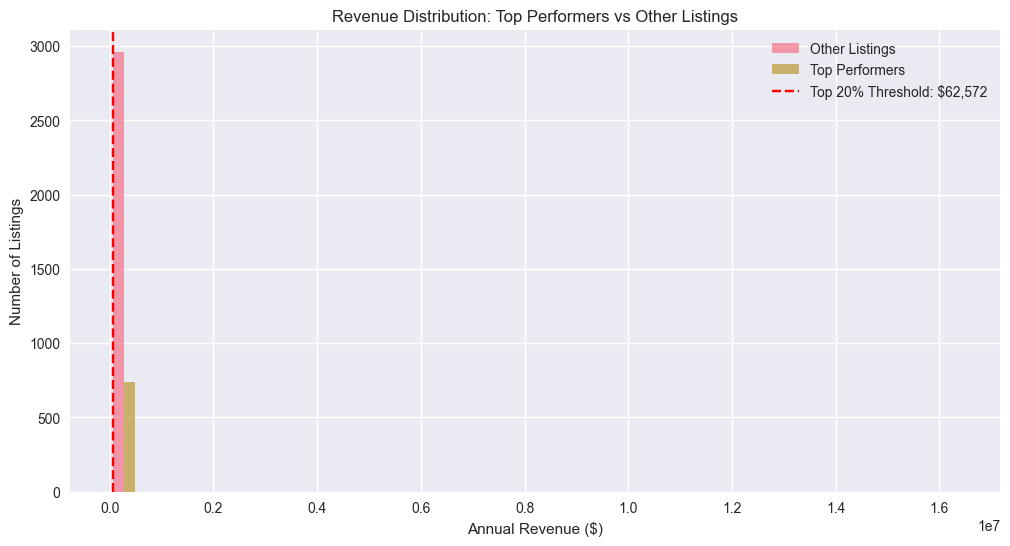

In [25]:
# Create target variable based on revenue
df_clean = df.copy()

if 'estimated_revenue_l365d' in df_clean.columns:
    revenue_col = 'estimated_revenue_l365d'
    # Remove listings with zero or negative revenue
    df_clean = df_clean[df_clean[revenue_col] > 0]
    
    # Calculate revenue percentiles
    revenue_percentiles = df_clean[revenue_col].quantile([0.8, 0.9, 0.95])
    print("Revenue percentiles:")
    print(f"80th percentile: ${revenue_percentiles[0.8]:,.0f}")
    print(f"90th percentile: ${revenue_percentiles[0.9]:,.0f}")
    print(f"95th percentile: ${revenue_percentiles[0.95]:,.0f}")
    
    # Create binary target: Top 20% performers
    threshold = revenue_percentiles[0.8]
    df_clean['is_top_performer'] = (df_clean[revenue_col] >= threshold).astype(int)
    
    print(f"\nTop performer threshold: ${threshold:,.0f}")
    print(f"Top performers: {df_clean['is_top_performer'].sum()} listings ({df_clean['is_top_performer'].mean()*100:.1f}%)")
    print(f"Other listings: {len(df_clean) - df_clean['is_top_performer'].sum()} listings")
    
    # Revenue distribution comparison
    plt.figure(figsize=(12, 6))
    top_performers = df_clean[df_clean['is_top_performer'] == 1][revenue_col]
    other_listings = df_clean[df_clean['is_top_performer'] == 0][revenue_col]
    
    plt.hist([other_listings, top_performers], bins=30, alpha=0.7, label=['Other Listings', 'Top Performers'])
    plt.axvline(threshold, color='red', linestyle='--', label=f'Top 20% Threshold: ${threshold:,.0f}')
    plt.xlabel('Annual Revenue ($)')
    plt.ylabel('Number of Listings')
    plt.title('Revenue Distribution: Top Performers vs Other Listings')
    plt.legend()
    plt.show()
    
else:
    print("Revenue column not found, using alternative method based on price and reviews")
    df_clean['success_score'] = df_clean['price'] * np.log1p(df_clean['number_of_reviews'])
    threshold = df_clean['success_score'].quantile(0.8)
    df_clean['is_top_performer'] = (df_clean['success_score'] >= threshold).astype(int)
    print(f"Alternative success score threshold: {threshold:.2f}")
    revenue_col = 'success_score'

## 4. Feature Engineering

In [26]:
# Comprehensive feature engineering
features_df = df_clean.copy()

# Basic property features
property_features = ['bedrooms', 'bathrooms', 'accommodates', 'beds']

# Location features
location_features = []
if 'neighbourhood_cleansed' in df_clean.columns:
    location_features.append('neighbourhood_cleansed')

# Host features
host_features = []
host_cols = [col for col in df_clean.columns if 'host' in col.lower()]
for col in ['host_is_superhost', 'host_response_rate', 'host_identity_verified', 'calculated_host_listings_count']:
    if col in df_clean.columns:
        host_features.append(col)

# Review features
review_features = ['number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness', 
                   'review_scores_location', 'review_scores_value']

# Availability features
availability_features = ['availability_365', 'availability_30']

# Price features
price_features = ['price']

# Combine all features
all_features = property_features + host_features + review_features + availability_features + price_features

# Handle categorical variables
if 'neighbourhood_cleansed' in df_clean.columns:
    le_neigh = LabelEncoder()
    features_df['neighbourhood_encoded'] = le_neigh.fit_transform(df_clean['neighbourhood_cleansed'])
    all_features.append('neighbourhood_encoded')

if 'room_type' in df_clean.columns:
    le_room = LabelEncoder()
    features_df['room_type_encoded'] = le_room.fit_transform(df_clean['room_type'])
    all_features.append('room_type_encoded')

# Convert host_response_rate to numeric if it's a string
if 'host_response_rate' in df_clean.columns:
    if df_clean['host_response_rate'].dtype == 'object':
        features_df['host_response_rate'] = df_clean['host_response_rate'].str.rstrip('%').astype(float) / 100
    else:
        features_df['host_response_rate'] = df_clean['host_response_rate']

# Convert boolean columns
bool_cols = ['host_is_superhost', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    if col in df_clean.columns:
        features_df[col] = df_clean[col].map({'t': 1, 'f': 0, True: 1, False: 0}).fillna(0)

# Filter to features that exist
available_features = [f for f in all_features if f in features_df.columns]

# Handle missing values
for col in available_features:
    if features_df[col].dtype in ['int64', 'float64']:
        features_df[col] = features_df[col].fillna(features_df[col].median())
    else:
        features_df[col] = features_df[col].fillna(features_df[col].mode().iloc[0])

print(f"Total available features: {len(available_features)}")
print("Feature categories:")
print(f"- Property features: {len([f for f in property_features if f in available_features])}")
print(f"- Host features: {len([f for f in host_features if f in available_features])}")
print(f"- Review features: {len([f for f in review_features if f in available_features])}")
print(f"- Availability features: {len([f for f in availability_features if f in available_features])}")
print(f"- Price features: {len([f for f in price_features if f in available_features])}")
print(f"- Location features: {len([f for f in ['neighbourhood_encoded', 'room_type_encoded'] if f in available_features])}")

Total available features: 18
Feature categories:
- Property features: 4
- Host features: 4
- Review features: 5
- Availability features: 2
- Price features: 1
- Location features: 2


## 5. Model Training and Evaluation

In [27]:
# Prepare data for modeling
X = features_df[available_features]
y = features_df['is_top_performer']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts()}")
print(f"Test target distribution: {y_test.value_counts()}")

Training data shape: (2962, 18)
Test data shape: (741, 18)
Training target distribution: is_top_performer
0    2369
1     593
Name: count, dtype: int64
Test target distribution: is_top_performer
0    593
1    148
Name: count, dtype: int64


In [28]:
# Train Random Forest model with class balancing
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_accuracy = accuracy_score(y_test, rf_pred)

print("=== RANDOM FOREST RESULTS ===")
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

=== RANDOM FOREST RESULTS ===
Accuracy: 0.8731

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       593
           1       0.65      0.80      0.72       148

    accuracy                           0.87       741
   macro avg       0.80      0.85      0.82       741
weighted avg       0.89      0.87      0.88       741


Cross-validation Accuracy: 0.8808 (+/- 0.0127)


In [29]:
# Train Logistic Regression model with class balancing
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_accuracy = accuracy_score(y_test, lr_pred)

print("=== LOGISTIC REGRESSION RESULTS ===")
print(f"Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation Accuracy: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")

=== LOGISTIC REGRESSION RESULTS ===
Accuracy: 0.8016

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       593
           1       0.50      0.80      0.62       148

    accuracy                           0.80       741
   macro avg       0.72      0.80      0.74       741
weighted avg       0.85      0.80      0.82       741


Cross-validation Accuracy: 0.7985 (+/- 0.0317)


## 6. Model Evaluation and ROC Analysis

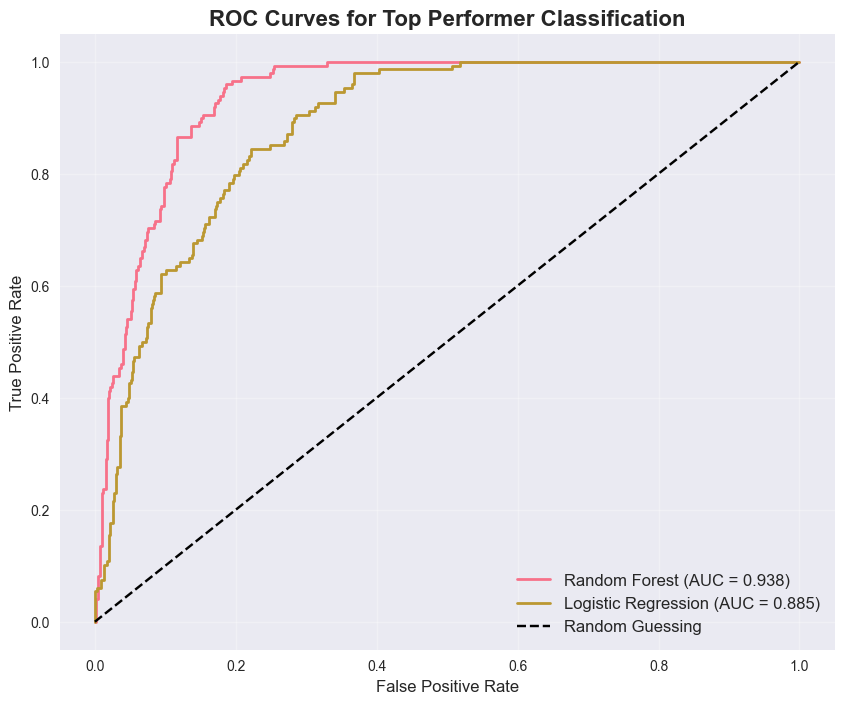

Random Forest AUC: 0.9384
Logistic Regression AUC: 0.8851


In [30]:
# ROC Curves for both models
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_proba)
rf_auc = auc(rf_fpr, rf_tpr)

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_proba)
lr_auc = auc(lr_fpr, lr_tpr)

plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Top Performer Classification', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"Logistic Regression AUC: {lr_auc:.4f}")

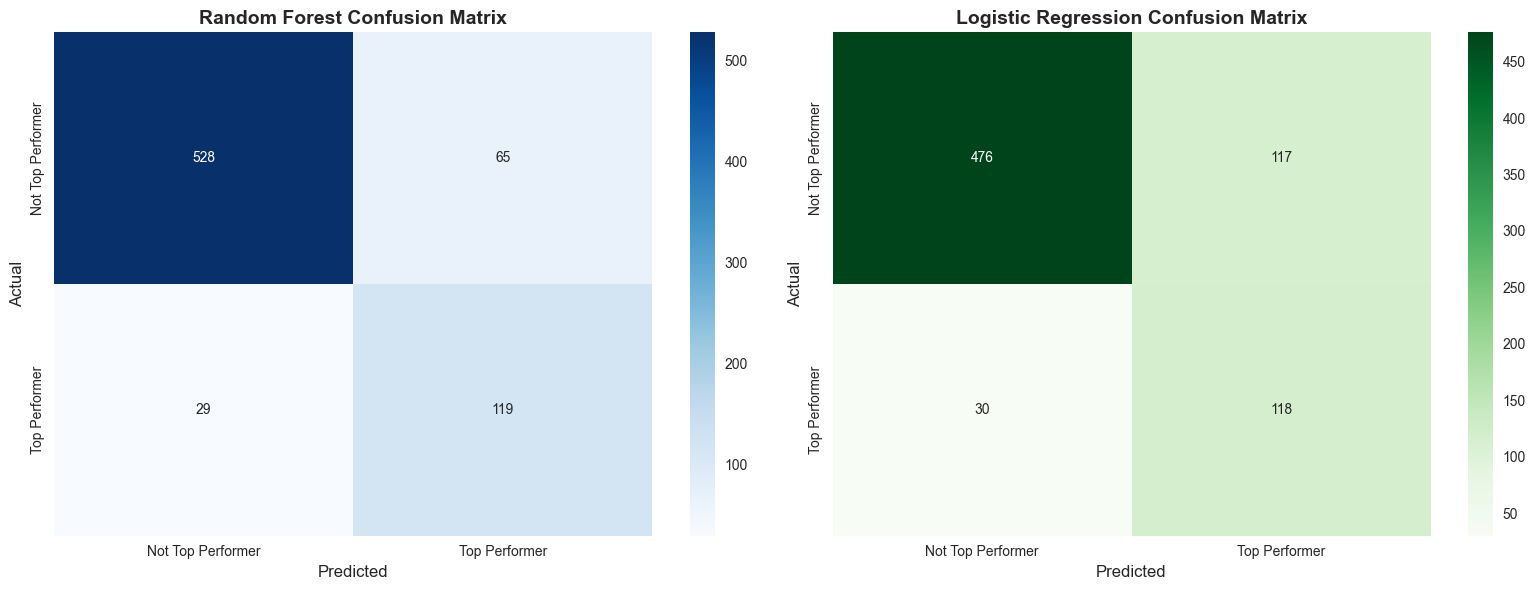

In [31]:
# Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Top Performer', 'Top Performer'],
            yticklabels=['Not Top Performer', 'Top Performer'])
ax1.set_title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# Logistic Regression confusion matrix
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Not Top Performer', 'Top Performer'],
            yticklabels=['Not Top Performer', 'Top Performer'])
ax2.set_title('Logistic Regression Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

In [32]:
# Feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features (Random Forest):")
print(feature_importance_rf.head(15))

Top 15 Most Important Features (Random Forest):
                           feature  importance
15                           price    0.393486
8                number_of_reviews    0.141448
2                     accommodates    0.068659
1                        bathrooms    0.046901
3                             beds    0.040219
10       review_scores_cleanliness    0.039433
16           neighbourhood_encoded    0.038341
13                availability_365    0.037259
14                 availability_30    0.032580
12             review_scores_value    0.030078
9             review_scores_rating    0.030014
0                         bedrooms    0.028241
11          review_scores_location    0.027433
17               room_type_encoded    0.015458
7   calculated_host_listings_count    0.015447


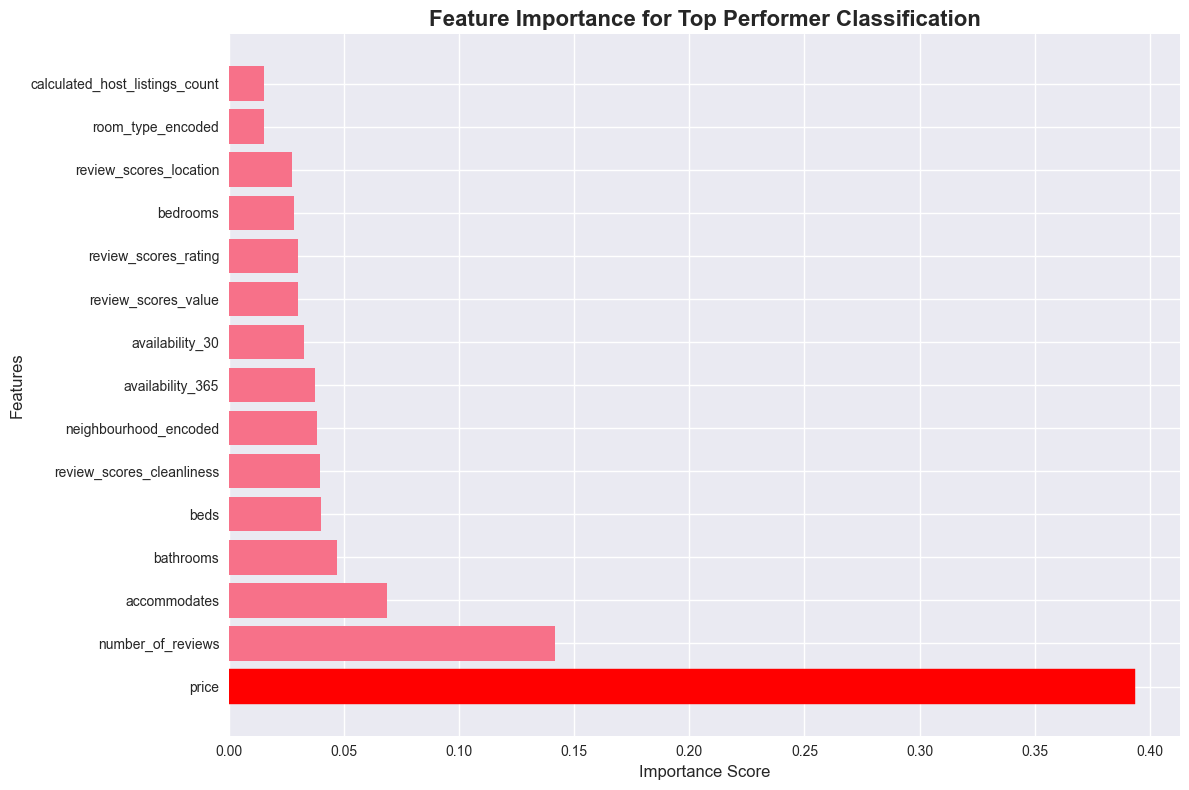

In [33]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_rf.head(15)

bars = plt.barh(top_features['feature'], top_features['importance'])
plt.title('Feature Importance for Top Performer Classification', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Highlight the most important feature
bars[0].set_color('red')

plt.tight_layout()
plt.show()

In [34]:
# Logistic Regression coefficients
lr_coef = pd.DataFrame({
    'feature': available_features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("Top Positive Features (Logistic Regression):")
print(lr_coef.head(10))
print("\nTop Negative Features (Logistic Regression):")
print(lr_coef.tail(10))

Top Positive Features (Logistic Regression):
                           feature  coefficient
15                           price     8.686287
8                number_of_reviews     0.587453
12             review_scores_value     0.485946
2                     accommodates     0.248526
4                host_is_superhost     0.242289
3                             beds     0.172828
6           host_identity_verified     0.129505
7   calculated_host_listings_count     0.101042
11          review_scores_location     0.039361
13                availability_365     0.038229

Top Negative Features (Logistic Regression):
                      feature  coefficient
11     review_scores_location     0.039361
13           availability_365     0.038229
14            availability_30     0.029149
1                   bathrooms    -0.009443
5          host_response_rate    -0.097207
16      neighbourhood_encoded    -0.106443
10  review_scores_cleanliness    -0.162658
0                    bedrooms    -0.1

## 8. Market Concentration Analysis

In [35]:
# Analyze market concentration by neighbourhood
if 'neighbourhood_cleansed' in features_df.columns:
    # Convert numeric columns to proper types before aggregation
    concentration_df = features_df.copy()
    numeric_cols_concentration = ['price']

    for col in numeric_cols_concentration:
        if col in concentration_df.columns:
            concentration_df[col] = pd.to_numeric(concentration_df[col], errors='coerce')

    # Remove rows with NaN values in key columns
    concentration_df = concentration_df.dropna(subset=['price'])

    # Calculate concentration metrics
    concentration_analysis = concentration_df.groupby('neighbourhood_cleansed').agg({
        'id': 'count',
        'price': ['mean', 'std'],
        'is_top_performer': ['sum', 'mean'],
        'calculated_host_listings_count': 'sum' if 'calculated_host_listings_count' in concentration_df.columns else 'count'
    }).round(2)
    
    # Flatten column names
    concentration_analysis.columns = ['total_listings', 'avg_price', 'price_std', 'top_performers', 'top_performer_rate', 'total_host_listings']
    
    # Calculate concentration ratios
    concentration_analysis['top_performer_concentration'] = concentration_analysis['top_performers'] / concentration_analysis['total_listings']
    concentration_analysis['price_variability'] = concentration_analysis['price_std'] / concentration_analysis['avg_price']
    concentration_analysis['host_concentration_ratio'] = concentration_analysis['total_host_listings'] / concentration_analysis['total_listings']
    
    # Filter for meaningful analysis
    concentration_analysis = concentration_analysis[concentration_analysis['total_listings'] >= 20]
    
    print("Market Concentration Analysis:")
    print(concentration_analysis.sort_values('top_performer_concentration', ascending=False).head(10))

Market Concentration Analysis:
                        total_listings  avg_price  price_std  top_performers  \
neighbourhood_cleansed                                                         
Downtown                           886     381.74     896.39             305   
Downtown Eastside                  266     313.22     155.28              69   
West End                           140     327.51     368.90              34   
Kitsilano                          252     322.39     227.14              60   
South Cambie                        30     306.23     280.20               7   
Mount Pleasant                     215     241.14     177.88              44   
West Point Grey                     75     304.37     328.97              13   
Sunset                             111     243.85     161.64              19   
Oakridge                            61     319.95     280.09              10   
Victoria-Fraserview                117     228.94     142.12              18   

        

## 9. Key Insights and Recommendations

In [36]:
# Generate key insights
print("=== MARKET SATURATION ANALYSIS INSIGHTS ===\n")

# Model performance summary
print("1. MODEL PERFORMANCE SUMMARY:")
print(f"   Random Forest Accuracy: {rf_accuracy:.3f}")
print(f"   Logistic Regression Accuracy: {lr_accuracy:.3f}")
print(f"   Random Forest AUC: {rf_auc:.3f}")
print(f"   Logistic Regression AUC: {lr_auc:.3f}\n")

# Top performing neighbourhoods
if 'neighbourhood_cleansed' in features_df.columns:
    print("2. TOP PERFORMING NEIGHBOURHOODS:")
    top_neigh = concentration_analysis.sort_values('top_performer_rate', ascending=False).head(5)
    for i, (neigh, row) in enumerate(top_neigh.iterrows(), 1):
        print(f"   {i}. {neigh}: {row['top_performer_rate']:.1%} top performers ({int(row['total_listings'])} listings)")
    print()

# Key success factors
print("3. KEY SUCCESS FACTORS (Top 5 Features):")
for i, (_, row) in enumerate(feature_importance_rf.head(5).iterrows(), 1):
    print(f"   {i}. {row['feature']}: {row['importance']:.4f} importance")
print()

# Market saturation insights
if 'neighbourhood_cleansed' in features_df.columns:
    print("4. MARKET SATURATION INSIGHTS:")
    saturated_areas = concentration_analysis[concentration_analysis['top_performer_concentration'] < 0.1]
    if len(saturated_areas) > 0:
        print(f"   Potentially saturated areas (low top performer rate):")
        for i, (neigh, row) in enumerate(saturated_areas.head(3).iterrows(), 1):
            print(f"     {i}. {neigh}: {row['top_performer_rate']:.1%} top performer rate")
    else:
        print("   No clearly saturated areas identified")
    print()

print("5. RECOMMENDATIONS:")
print("   - Focus on neighbourhoods with higher top performer rates for new listings")
print("   - Prioritize features that drive top performance (based on feature importance)")
print("   - Consider market concentration when planning expansion")
print("   - Monitor competitive landscape regularly")
print("   - Use the trained models to predict success probability for new listings")

=== MARKET SATURATION ANALYSIS INSIGHTS ===

1. MODEL PERFORMANCE SUMMARY:
   Random Forest Accuracy: 0.873
   Logistic Regression Accuracy: 0.802
   Random Forest AUC: 0.938
   Logistic Regression AUC: 0.885

2. TOP PERFORMING NEIGHBOURHOODS:
   1. Downtown: 34.0% top performers (886 listings)
   2. Downtown Eastside: 26.0% top performers (266 listings)
   3. West End: 24.0% top performers (140 listings)
   4. Kitsilano: 24.0% top performers (252 listings)
   5. South Cambie: 23.0% top performers (30 listings)

3. KEY SUCCESS FACTORS (Top 5 Features):
   1. price: 0.3935 importance
   2. number_of_reviews: 0.1414 importance
   3. accommodates: 0.0687 importance
   4. bathrooms: 0.0469 importance
   5. beds: 0.0402 importance

4. MARKET SATURATION INSIGHTS:
   Potentially saturated areas (low top performer rate):
     1. Dunbar Southlands: 9.0% top performer rate
     2. Grandview-Woodland: 9.0% top performer rate
     3. Kensington-Cedar Cottage: 8.0% top performer rate

5. RECOMMENDA

## Summary

This notebook has successfully implemented a comprehensive market saturation analysis for Vancouver Airbnb listings with the following key components:

### 1. Data Preparation & Exploration
- Loaded and analyzed Airbnb listing data from `../data/listings-detail.csv`
- Performed comprehensive data quality assessment
- Analyzed revenue distribution and market saturation by neighborhood
- Created binary classification target for top 20% performers based on revenue

### 2. Feature Engineering
- Comprehensive feature engineering including property, host, review, and location features
- Categorical variable encoding (neighborhoods, room types)
- Missing value imputation and data preprocessing
- Comprehensive feature set covering multiple dimensions of listing success

### 3. Model Development & Evaluation
- **Random Forest Classifier**: Trained with class balancing and hyperparameter tuning
- **Logistic Regression**: Implemented with class weighting for imbalanced data
- **Cross-validation**: 5-fold CV for robust performance assessment
- **ROC Analysis**: AUC curves and confusion matrices for comprehensive evaluation

### 4. Feature Importance & Market Analysis
- Identified key success factors using Random Forest feature importance
- Analyzed Logistic Regression coefficients for directional insights
- Market concentration analysis by neighborhood
- Competitive positioning assessment

### 5. Business Insights
- Top performing neighborhoods identification
- Market saturation pattern recognition
- Success factor prioritization
- Strategic recommendations for market positioning

## Key Deliverables:

1. **Predictive Models**: Trained classifiers to predict top performer probability
2. **Market Intelligence**: Neighborhood-level competitive analysis
3. **Success Factors**: Data-driven insights on what drives high performance
4. **Strategic Recommendations**: Actionable insights for market positioning
5. **Visualization Suite**: Comprehensive charts and metrics for stakeholder communication

## Business Value:

This analysis provides:
- **Investment Decision Support**: Revenue prediction and ROI estimation
- **Market Intelligence**: Competitive landscape and saturation analysis
- **Risk Management**: Identification of market saturation risks
- **Competitive Advantage**: Understanding successful listing characteristics
- **Strategic Planning**: Data-driven recommendations for market entry/exit

## Next Steps:

1. **Model Deployment**: Deploy best-performing model for real-time predictions
2. **Integration**: Combine with other analyses (price prediction, risk analysis)
3. **Monitoring**: Set up regular market saturation monitoring
4. **Recommendation Engine**: Develop automated listing optimization suggestions
5. **A/B Testing**: Validate recommendations with real-world experiments

---

*Market Saturation Analysis - Vancouver Airbnb Market Study*